In [ ]:
# !pip install transformers
# !pip install torch
# !pip install datasets evaluate rouge_score sacremoses pillow
# !pip install -U transformers[torch] transformers[sentencepiece]

In [ ]:

from transformers import VisionEncoderDecoderModel, AutoTokenizer, AutoFeatureExtractor
import torch

# the encoder model that process the image and return the image features
# encoder_model = "WinKawaks/vit-small-patch16-224"
# encoder_model = "google/vit-base-patch16-224"
# encoder_model = "google/vit-base-patch16-224-in21k"
encoder_model = "microsoft/swinv2-tiny-patch4-window8-256"
# the decoder model that process the image features and generate the caption text
# decoder_model = "bert-base-uncased"
# decoder_model = "prajjwal1/bert-tiny"
decoder_model = "gpt2"
# load the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(
    encoder_model, decoder_model
).to(device)

In [ ]:
model_name = 'swin-gpt-en_v0.1'

model_dir = f'./models/{model_name}'
model_output_dir = f'{model_dir}/image-captioning-output'
output_dir = f'{model_dir}/swin-gpt-model'

In [ ]:
from transformers import GPT2TokenizerFast, ViTImageProcessor
import torch

# initialize the tokenizer
# tokenizer = AutoTokenizer.from_pretrained(decoder_model)
tokenizer = GPT2TokenizerFast.from_pretrained(decoder_model)
# tokenizer = BertTokenizerFast.from_pretrained(decoder_model)
# load the image processor
image_processor = ViTImageProcessor.from_pretrained(encoder_model)

In [ ]:
if "gpt2" in decoder_model:
  # gpt2 does not have decoder_start_token_id and pad_token_id
  # but has bos_token_id and eos_token_id
  tokenizer.pad_token = tokenizer.eos_token # pad_token_id as eos_token_id
  model.config.eos_token_id = tokenizer.eos_token_id
  model.config.pad_token_id = tokenizer.pad_token_id
  # set decoder_start_token_id as bos_token_id
  model.config.decoder_start_token_id = tokenizer.bos_token_id
else:
  # set the decoder start token id to the CLS token id of the tokenizer
  model.config.decoder_start_token_id = tokenizer.cls_token_id
  # set the pad token id to the pad token id of the tokenizer
  model.config.pad_token_id = tokenizer.pad_token_id

In [ ]:
from datasets import load_dataset

max_length = 32 # max length of the captions in tokens
train_ds = load_dataset("jxie/flickr8k", split="train")
valid_ds = load_dataset("jxie/flickr8k", split="validation")
test_ds = load_dataset("jxie/flickr8k", split="test")
len(train_ds), len(valid_ds), len(test_ds)

In [ ]:
import numpy as np

# remove the images with less than 3 dimensions (possibly grayscale images)
train_ds = train_ds.filter(lambda item: np.array(item["image"]).ndim in [3, 4], num_proc=2)
valid_ds = valid_ds.filter(lambda item: np.array(item["image"]).ndim in [3, 4], num_proc=2)
test_ds = test_ds.filter(lambda item: np.array(item["image"]).ndim in [3, 4], num_proc=2)


In [ ]:
from datasets import Dataset

def duplicate_elements(arr, n):
    return sum(([x] * n for x in arr), [])

img_index = 0

def preprocess_for_caption(items):
    global img_index
    curr_image = items["image"][0]
    # preprocess the image
    pixel_values = image_processor(curr_image, return_tensors="pt").pixel_values.to(device)
    caption = items[f'caption_{img_index}']

    if img_index == 4:
        img_index = 0
    else:
        img_index = img_index + 1
    # tokenize the caption with truncation and padding
    targets = tokenizer(caption, 
                        max_length=max_length, padding="max_length", truncation=True, return_tensors="pt").to(device)
    
    return {'pixel_values': pixel_values, 'labels': targets["input_ids"], 'caption': caption}

def create_dic(items):
    data_dict = {}
    for key in items[0].keys():
        data_dict[key] = [obj[key] for obj in items]

    return Dataset.from_dict(data_dict)


In [ ]:
duplicated_train_ds = duplicate_elements(train_ds, 3)
del train_ds
train_dic = create_dic(duplicated_train_ds)

In [ ]:
duplicated_valid_ds = duplicate_elements(valid_ds, 3)
del valid_ds
valid_dic = create_dic(duplicated_valid_ds)


In [ ]:
duplicated_test_ds = duplicate_elements(test_ds, 3)
del test_ds
test_dic = create_dic(duplicated_test_ds)


In [ ]:
train_dataset = train_dic.with_transform(preprocess_for_caption)
valid_dataset = valid_dic.with_transform(preprocess_for_caption)
test_dataset  = test_dic.with_transform(preprocess_for_caption)

In [ ]:
display(test_dataset[555]['caption'])
display(test_dataset[555]['caption'])
display(test_dataset[555]['caption'])


In [ ]:
# a function we'll use to collate the batches
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.stack([x['labels'] for x in batch])
    }

In [ ]:
import evaluate

# load the rouge and bleu metrics
rouge = evaluate.load("rouge")
bleu = evaluate.load("bleu")
  
def compute_metrics(eval_pred):
  preds = eval_pred.label_ids
  labels = eval_pred.predictions
  # decode the predictions and labels
  pred_str = tokenizer.batch_decode(preds, skip_special_tokens=True)
  labels_str = tokenizer.batch_decode(labels, skip_special_tokens=True)
  # compute the rouge score
  rouge_result = rouge.compute(predictions=pred_str, references=labels_str)
  # multiply by 100 to get the same scale as the rouge score
  rouge_result = {k: round(v * 100, 4) for k, v in rouge_result.items()}
  # compute the bleu score
  bleu_result = bleu.compute(predictions=pred_str, references=labels_str)
  # get the length of the generated captions
  generation_length = bleu_result["translation_length"]
  return {
        **rouge_result, 
        "bleu": round(bleu_result["bleu"] * 100, 4), 
        "gen_len": bleu_result["translation_length"] / len(preds)
  }

In [ ]:
num_epochs = 2 # number of epochs
batch_size = 16 # the size of batches

In [ ]:
for item in train_dataset:
  print(item["labels"].shape)
  print(item["pixel_values"].shape)
  break

In [ ]:
torch.Size([32])
torch.Size([3, 224, 224])

In [ ]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

# define the training arguments
training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,             # use generate to calculate the loss
    num_train_epochs=num_epochs,            # number of epochs
    evaluation_strategy="steps",            # evaluate after each eval_steps
    eval_steps=2000,                        # evaluate after each 2000 steps
    logging_steps=2000,                     # log after each 2000 steps
    save_steps=2000,                        # save after each 2000 steps
    per_device_train_batch_size=batch_size, # batch size for training
    per_device_eval_batch_size=batch_size,  # batch size for evaluation
    output_dir="vit-swin-base-224-gpt2-image-captioning", # output directory
    # push_to_hub=True # whether you want to push the model to the hub,
    # check this guide for more details: https://huggingface.co/transformers/model_sharing.html
)

In [ ]:
# instantiate trainer
trainer = Seq2SeqTrainer(
    model=model,                     # the instantiated 🤗 Transformers model to be trained
    tokenizer=image_processor,       # we use the image processor as the tokenizer
    args=training_args,              # pass the training arguments
    compute_metrics=compute_metrics, 
    train_dataset=train_dataset,     
    eval_dataset=valid_dataset,      
    data_collator=collate_fn,        
)

In [ ]:
from torch.utils.data import DataLoader

def get_eval_loader(eval_dataset=None):
  return DataLoader(valid_dataset, collate_fn=collate_fn, batch_size=batch_size)

def get_test_loader(eval_dataset=None):
  return DataLoader(test_dataset, collate_fn=collate_fn, batch_size=batch_size)

# override the get_train_dataloader, get_eval_dataloader and
# get_test_dataloader methods of the trainer
# so that we can properly load the data
trainer.get_train_dataloader = lambda: DataLoader(train_dataset, collate_fn=collate_fn, batch_size=batch_size)
trainer.get_eval_dataloader = get_eval_loader
trainer.get_test_dataloader = get_test_loader

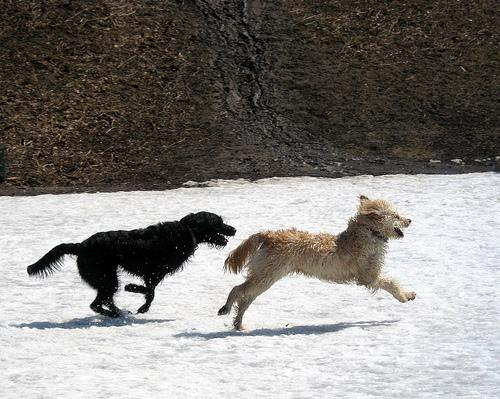

Step,Training Loss,Validation Loss


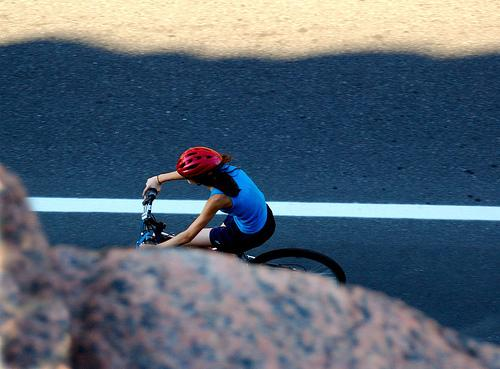

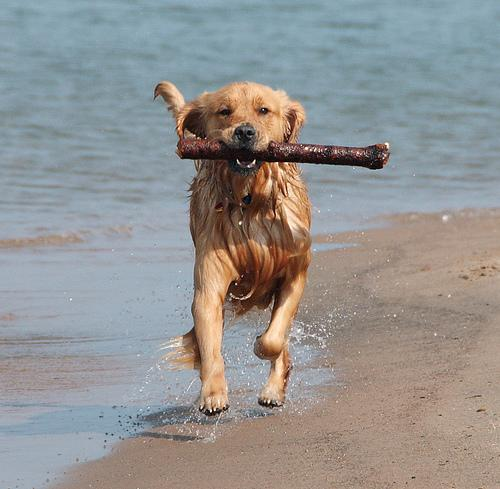

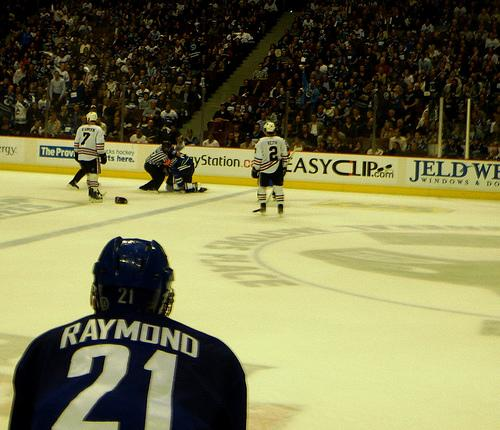

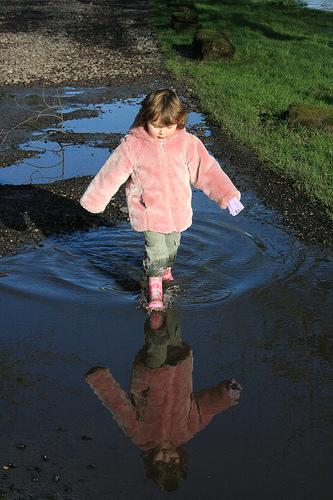

KeyboardInterrupt: 

In [22]:
# train the model
trainer.train()

In [ ]:
trainer.save_model(model_output_dir)
tokenizer.save_pretrained(model_output_dir)

In [ ]:
import glob

image_paths = []
for filename in glob.glob('./image-samples/*.jpg'): 
  image_paths.append(filename)

predict_step(image_paths)